In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit

In [ ]:
# have 3 products - need function for creating model outputs
# optimisation

# Should X effect T?
# How could the model fit better? Is it the noise term?
# improve visualisations

# Non-linear treatment effects in Pricing & Promotions

In [2]:
def michaelis_menten(x, alpha, lam):
    return alpha * x / (lam + x)

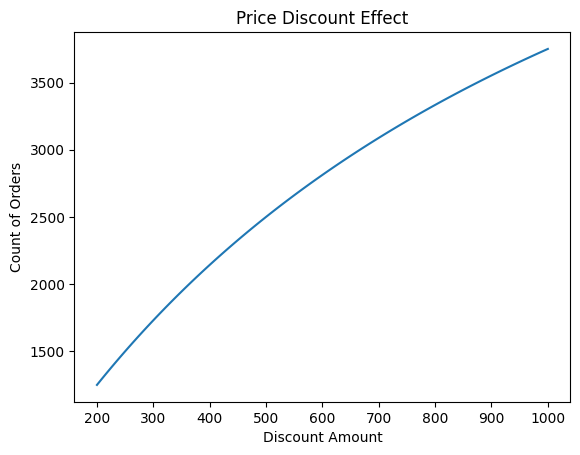

In [5]:
# michaelis_menten params
alpha = 10000
lam = 1000

# treatment effect
tau = 0.75

linear_x = np.linspace(200, 1000, 100)

nonlinear_x = michaelis_menten(linear_x, alpha, lam)
nonlinear_y = nonlinear_x * tau

sns.lineplot(x=linear_x, y=nonlinear_y)
plt.title('Price Discount Effect')
plt.ylabel('Count of Orders')
plt.xlabel('Discount Amount')
plt.show()

# Data generating process

|Variable|Description|
|-|-|
|x0|Demand|
|x1|Marketing spend|
|x2|Competitor discount amount|
|x3|Competitor marketing spend|
|T|Discount amount|
|y|Count of orders|

In [41]:
def data_generator(tau_weight):
    
    # Set number of observations
    n=10000

    # Set number of features
    p=4

    # Create features
    X = np.random.uniform(size=n * p).reshape((n, -1))

    # Nuisance parameters
    b = (
        np.sin(np.pi * X[:, 0])
        + 2 * (X[:, 1] - 0.5) ** 2
        + X[:, 2] * X[:, 3]
    )

    # Treatment effect
    alpha = 2
    lam = 5000

    T = np.linspace(200, 10000, 10000)
    T_mm = michaelis_menten(T, alpha, lam)
    tau = T_mm / T

    # Calculate outcome
    y = b + T * tau + np.random.normal(size=n)
    
    y_train = y
    X_train = np.hstack((X, T.reshape(-1, 1)))
    
    return y_train, X_train, T_mm

In [42]:
y_train_1, X_train_1, T_mm = data_generator(1.00)
y_train_2, X_train_2, T_mm  = data_generator(0.75)
y_train_3, X_train_3, T_mm  = data_generator(1.25)

# S-Learner

In [43]:
model = LGBMRegressor(random_state=42)
model.fit(X_train_1, y_train_1)

yhat_train_1 = model.predict(X_train_1)

mse_train_1 = mean_squared_error(y_train_1, yhat_train_1)
r2_train_1 = r2_score(y_train_1, yhat_train_1)

print(f'MSE on train set is {round(mse_train_1)}')
print(f'R2 on train set is {round(r2_train_1, 2)}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 5
[LightGBM] [Info] Start training from score 1.970347
MSE on train set is 1
R2 on train set is 0.39


<Axes: >

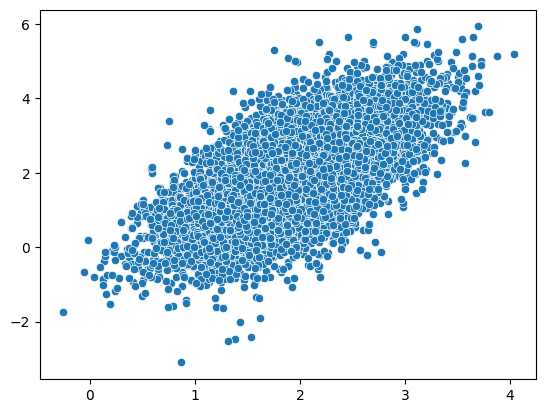

In [44]:
sns.scatterplot(x=yhat_train_1, y=y_train_1)

# Extracting treatment effect

In [45]:
# Set features to mean value
X_mean_mapping = {'X1': [X_train_1[:, 0].mean()] * 10000,
                  'X2': [X_train_1[:, 1].mean()] * 10000,
                  'X3': [X_train_1[:, 2].mean()] * 10000,
                  'X4': [X_train_1[:, 3].mean()] * 10000}

# Create DataFrame
df_scoring = pd.DataFrame(X_mean_mapping)

# Add full range of treatment values
df_scoring['T'] = X_train_1[:, 4].reshape(-1, 1)
df_scoring

,X1,X2,X3,X4,T
0,0.503666,0.500414,0.498339,0.502793,200.000000
1,0.503666,0.500414,0.498339,0.502793,200.980098
2,0.503666,0.500414,0.498339,0.502793,201.960196
3,0.503666,0.500414,0.498339,0.502793,202.940294
4,0.503666,0.500414,0.498339,0.502793,203.920392
...,...,...,...,...,...
9995,0.503666,0.500414,0.498339,0.502793,9996.079608
9996,0.503666,0.500414,0.498339,0.502793,9997.059706
9997,0.503666,0.500414,0.498339,0.502793,9998.039804
9998,0.503666,0.500414,0.498339,0.502793,9999.019902


In [46]:
treated = model.predict(df_scoring)

In [47]:
# Set features to mean value
X_mean_mapping2 = {'X1': [X_train_1[:, 0].mean()] * 10000,
                   'X2': [X_train_1[:, 1].mean()] * 10000,
                   'X3': [X_train_1[:, 2].mean()] * 10000,
                   'X4': [X_train_1[:, 3].mean()] * 10000,
                   'T': [0] * 10000}

# Create DataFrame
df_scoring2 = pd.DataFrame(X_mean_mapping2)

# Add full range of treatment values
df_scoring2

,X1,X2,X3,X4,T
0,0.503666,0.500414,0.498339,0.502793,0
1,0.503666,0.500414,0.498339,0.502793,0
2,0.503666,0.500414,0.498339,0.502793,0
3,0.503666,0.500414,0.498339,0.502793,0
4,0.503666,0.500414,0.498339,0.502793,0
...,...,...,...,...,...
9995,0.503666,0.500414,0.498339,0.502793,0
9996,0.503666,0.500414,0.498339,0.502793,0
9997,0.503666,0.500414,0.498339,0.502793,0
9998,0.503666,0.500414,0.498339,0.502793,0


In [48]:
untreated = model.predict(df_scoring2)

In [49]:
treatment_effect = treated - untreated

<Axes: xlabel='T'>

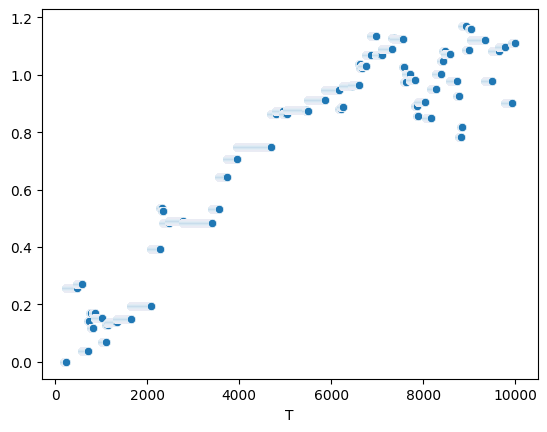

In [50]:
sns.scatterplot(x=df_scoring['T'], y=treatment_effect)

<Axes: xlabel='T'>

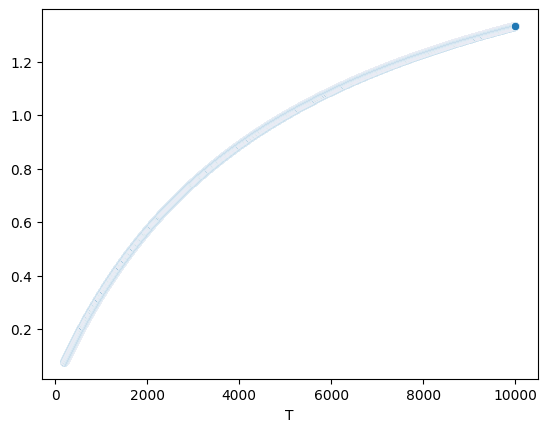

In [53]:
sns.scatterplot(x=df_scoring['T'], y=T_mm)

# Curve fit

In [27]:
maxfev = 100000
lam_initial_estimate = 0.001
alpha_initial_estimate = max(treatment_effect)
initial_guess = [alpha_initial_estimate, lam_initial_estimate]

popt, pcov = curve_fit(michaelis_menten, T, treatment_effect, p0=initial_guess, maxfev=maxfev)

In [29]:
popt[0]

2.1875529633110546

In [30]:
popt[1]

6820.768333545096

In [31]:
treatment_effect_curve = michaelis_menten(T, popt[0], popt[1])

<Axes: >

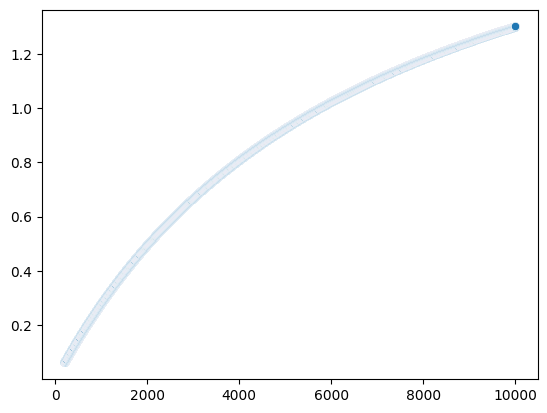

In [32]:
sns.scatterplot(x=T, y=treatment_effect_curve)

<Axes: >

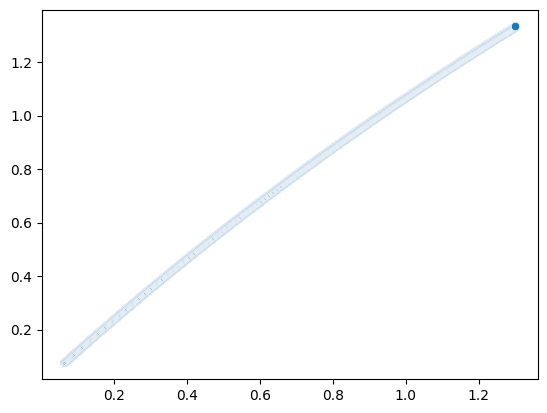

In [33]:
sns.scatterplot(x=treatment_effect_curve, y=T_mm)

# Optimisation

In [ ]:
def optimize_budget_distribution(
    method: str,
    total_budget: int,
    budget_ranges: dict[str, tuple[float, float]] | None,
    parameters: dict[str, tuple[float, float]],
    channels: list[str],
) -> dict[str, float]:
    """
    Optimize the budget allocation across channels to maximize total contribution.

    Using the Michaelis-Menten or Sigmoid function, this function seeks the best budget distribution across
    channels that maximizes the total expected contribution.

    This function leverages the Sequential Least Squares Quadratic Programming (SLSQP) optimization
    algorithm to find the best budget distribution across channels that maximizes the total
    expected contribution based on the Michaelis-Menten or Sigmoid functions.

    The optimization is constrained such that:
    1. The sum of budgets across all channels equals the total available budget.
    2. The budget allocated to each individual channel lies within its specified range.

    The SLSQP method is particularly suited for this kind of problem as it can handle
    both equality and inequality constraints.

    Parameters
    ----------
    total_budget : int
        The total budget to be distributed across channels.
    budget_ranges : Dict or None
        An optional dictionary defining the minimum and maximum budget for each channel.
        If not provided, the budget for each channel is constrained between 0 and its L value.
    parameters : Dict
        Michaelis-Menten parameters for each channel as described in `calculate_expected_contribution`.
    channels : list of str
        The list of channels for which the budget is being optimized.

    Returns
    -------
    Dict
        A dictionary with channels as keys and the optimal budget for each channel as values.
    """

    # Check if budget_ranges is the correct type
    if not isinstance(budget_ranges, dict | type(None)):
        raise TypeError("`budget_ranges` should be a dictionary or None.")

    if budget_ranges is None:
        budget_ranges = {
            channel: (0, min(total_budget, parameters[channel][0]))
            for channel in channels
        }

    initial_guess = [total_budget // len(channels)] * len(channels)

    bounds = [budget_ranges[channel] for channel in channels]

    constraints = {"type": "eq", "fun": lambda x: np.sum(x) - total_budget}

    result = minimize(
        lambda x: objective_distribution(x, method, channels, parameters),
        initial_guess,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
    )

    return {
        channel: budget for channel, budget in zip(channels, result.x, strict=False)
    }